In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy.stats as st
from collections import Counter
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *
import seaborn as sns
from scipy.stats import ks_2samp
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Table of Contents

* [I.Nettoyage de données](#chapter1)
    * [1) Données mensuelles de consommation totale d'électricité](#section_1_1)
    * [2) Données de l'effet température](#section_1_2)
* [II. Correction des données de consommation de l'effet température ](#chapter2)
* [III. Désaisonnalisation de la consommation grâce aux moyennes mobiles ](#chapter3)
* [IV. Prévision de la consommation ](#chapter4)
    * [1) Méthode de Holt-Winters](#section_4_1)
    * [2) Méthodes SARIMA](#section_4_2)

# I. Nettoyage de données <a class="anchor" id="chapter1"></a>

## 1) Données mensuelles de consommation totale d'électricité <a class="anchor" id="section_1_1"></a>

In [2]:
energie = pd.read_excel("energie.xls")
energie.drop(energie.columns[14:22],axis=1,inplace=True)
energie

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Consommation totale
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514,51086
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454,54476
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,356,531,43156
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,329,405,40176
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,974,454,469,35257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,2021-04,Données consolidées,Occitanie,3254,1815.0,0,0.0,0,0,787,283,306,60,2913
1308,2021-04,Données consolidées,Normandie,4602,4260.0,148,-2.0,15,136,7,110,29,45,2283
1309,2021-04,Données consolidées,Hauts-de-France,4271,2538.0,874,0.0,2,871,1,749,31,75,4098
1310,2021-04,Données consolidées,PACA,1363,0.0,582,-1.0,17,566,521,14,191,54,3211


## 2) Données de l'effet température  <a class="anchor" id="section_1_2"></a>

In [3]:
energ_tot = energie[(energie['Territoire']=='France')]
energ_tot = energ_tot.loc[:,['Mois','Consommation totale']]
energ_tot.describe(include='all')

,Mois,Consommation totale
count,112,112.000000
unique,112,NaN
top,2019-04,NaN
freq,1,NaN
mean,NaN,39902.607143
std,NaN,7089.857605
min,NaN,30622.000000
25%,NaN,33484.250000
50%,NaN,37740.000000
75%,NaN,45047.500000


In [4]:
energ_tot

,Mois,Consommation totale
0,2012-01,51086
1,2012-02,54476
2,2012-03,43156
3,2012-04,40176
4,2012-05,35257
...,...,...
1253,2020-12,47565
1266,2021-01,53020
1279,2021-02,43040
1292,2021-03,43856


In [5]:
energ_tot = energ_tot[(energ_tot['Mois'] >= '2012-01') & (energ_tot['Mois'] <= '2019-12')]
energ_tot

,Mois,Consommation totale
0,2012-01,51086
1,2012-02,54476
2,2012-03,43156
3,2012-04,40176
4,2012-05,35257
...,...,...
1045,2019-08,31564
1058,2019-09,32213
1071,2019-10,36367
1084,2019-11,43945


In [6]:
dju = pd.read_excel("djuok.xlsx")
dju = dju.drop(['Année', 'Total'], axis=1)
dju

,Jan,Fév,Mar,Avr,Mai,Jun,Jui,Aoû,Sep,Oct,Nov,Déc
0,405,268,233,169,118,24,0,2,27,134,283,327
1,303,433,314,120,56,8,0,3,34,122,283,326
2,468,278,206,183,75,9,1,7,63,99,283,369
3,364,322,321,212,88,28,6,3,12,176,286,391
4,392,366,276,141,92,16,7,6,72,177,195,248
5,324,282,224,136,100,19,8,19,16,92,223,368
6,429,402,377,210,158,44,1,5,42,105,304,350
7,336,436,202,230,83,35,12,2,58,155,296,346


# II. Correction des données de consommation de l'effet température <a class="anchor" id="chapter2"></a>

In [7]:
graph = dju.T
année_2019 = graph.loc[:,[0]].rename(columns={0: 'Données météo'})
année_2018 = graph.loc[:,[1]].rename(columns={1: 'Données météo'})
année_2017 = graph.loc[:,[2]].rename(columns={2: 'Données météo'})
année_2016 = graph.loc[:,[3]].rename(columns={3: 'Données météo'})
année_2015 = graph.loc[:,[4]].rename(columns={4: 'Données météo'})
année_2014 = graph.loc[:,[5]].rename(columns={5: 'Données météo'})
année_2013 = graph.loc[:,[6]].rename(columns={6: 'Données météo'})
année_2012 = graph.loc[:,[7]].rename(columns={7: 'Données météo'})
graph

,0,1,2,3,4,5,6,7
Jan,405,303,468,364,392,324,429,336
Fév,268,433,278,322,366,282,402,436
Mar,233,314,206,321,276,224,377,202
Avr,169,120,183,212,141,136,210,230
Mai,118,56,75,88,92,100,158,83
Jun,24,8,9,28,16,19,44,35
Jui,0,0,1,6,7,8,1,12
Aoû,2,3,7,3,6,19,5,2
Sep,27,34,63,12,72,16,42,58
Oct,134,122,99,176,177,92,105,155


In [8]:
année_2012

,Données météo
Jan,336
Fév,436
Mar,202
Avr,230
Mai,83
Jun,35
Jui,12
Aoû,2
Sep,58
Oct,155


In [9]:
conso_a = pd.concat([année_2012, année_2013, année_2014, année_2015, année_2016, année_2017, année_2018, année_2019])
list = energ_tot['Mois'].tolist()
conso_a['Mois'] = list
conso_a

,Données météo,Mois
Jan,336,2012-01
Fév,436,2012-02
Mar,202,2012-03
Avr,230,2012-04
Mai,83,2012-05
...,...,...
Aoû,2,2019-08
Sep,27,2019-09
Oct,134,2019-10
Nov,283,2019-11


In [10]:
conso = pd.merge(conso_a, energ_tot)
conso = conso.reindex(columns=['Mois','Consommation totale','Données météo'])
conso = conso.rename(columns={'Consommation totale': 'Consommation_totale', 'Données météo': 'Données_météo'})
conso

,Mois,Consommation_totale,Données_météo
0,2012-01,51086,336
1,2012-02,54476,436
2,2012-03,43156,202
3,2012-04,40176,230
4,2012-05,35257,83
...,...,...,...
91,2019-08,31564,2
92,2019-09,32213,27
93,2019-10,36367,134
94,2019-11,43945,283


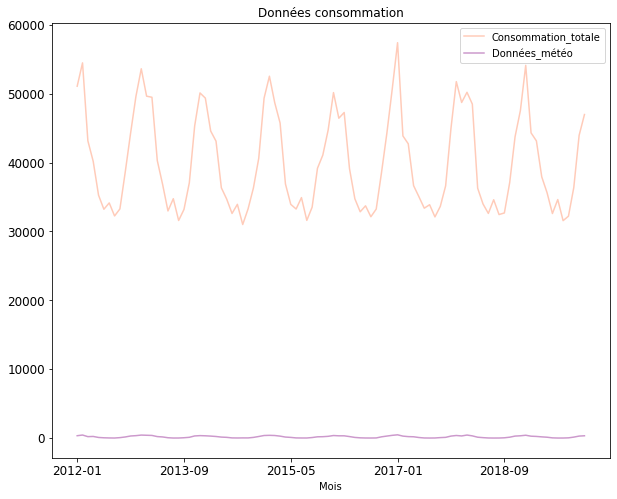

In [11]:
conso.plot(x ='Mois', alpha=0.4, color=['coral', 'purple'],figsize=(10, 8), title='Données consommation', fontsize=12)
plt.show()

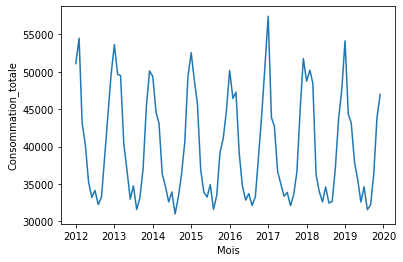

In [50]:
sns.lineplot(x='Mois', y='Consommation_totale', data = conso)
sns.figsize=(7,9)

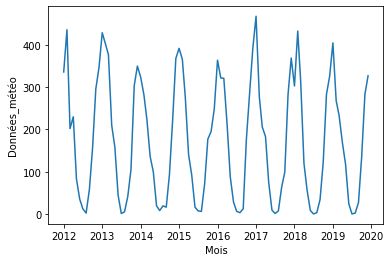

In [51]:
sns.lineplot(x='Mois', y='Données_météo', data = conso)
sns.figsize=(7,8)

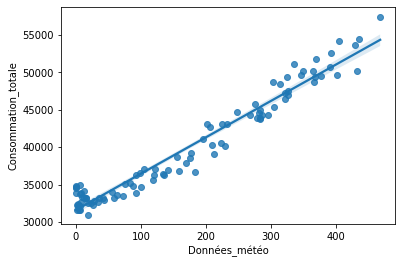

In [14]:
sns.regplot(x='Données_météo', y='Consommation_totale', data = conso)
sns.figsize=(7,8)

In [15]:
conso_ajust = smf.ols('Consommation_totale ~ Données_météo', data = conso).fit()
print(conso_ajust.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation_totale   R-squared:                       0.953
Model:                             OLS   Adj. R-squared:                  0.952
Method:                  Least Squares   F-statistic:                     1904.
Date:                 Sun, 04 Jul 2021   Prob (F-statistic):           3.38e-64
Time:                         23:27:11   Log-Likelihood:                -840.12
No. Observations:                   96   AIC:                             1684.
Df Residuals:                       94   BIC:                             1689.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.159e+04    249.427 

In [16]:
print(conso_ajust.params)

Intercept        31593.785430
Données_météo       48.599232
dtype: float64


In [17]:
conso_ajust.params[1]

48.59923157112471

In [18]:
conso['Predicted'] = conso_ajust.predict()
conso['Corrigés'] = conso['Consommation_totale'] - conso_ajust.params[1] * conso['Données_météo']
conso

,Mois,Consommation_totale,Données_météo,Predicted,Corrigés
0,2012-01,51086,336,47923.127238,34756.658192
1,2012-02,54476,436,52783.050395,33286.735035
2,2012-03,43156,202,41410.830207,33338.955223
3,2012-04,40176,230,42771.608691,28998.176739
4,2012-05,35257,83,35627.521650,31223.263780
...,...,...,...,...,...
91,2019-08,31564,2,31690.983893,31466.801537
92,2019-09,32213,27,32905.964682,30900.820748
93,2019-10,36367,134,38106.082460,29854.702969
94,2019-11,43945,283,45347.367964,30191.417465


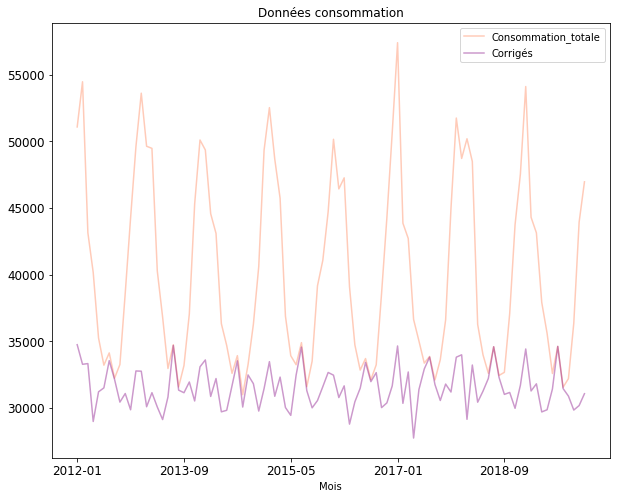

In [19]:
pics = conso.loc[:,['Mois','Consommation_totale','Corrigés']]
pics.plot(x ='Mois', alpha=0.4, color=['coral', 'purple', 'darkgreen','blue'],figsize=(10, 8), title='Données consommation', fontsize=12)
plt.show()

L'idée est de lisser les pics d'hiver et d'été. L'amplitude des pics devient plus comparable.

#### Testez l’homoscédasticité
On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [20]:
variables = conso_ajust.model.exog
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(conso_ajust.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.29369741148953277


La p-valeur ici est supérieure à $5$%, on ne rejette donc pas l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

#### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [21]:
shapiro(conso_ajust.resid)

(0.9791253209114075, 0.12932679057121277)

pvalue > 0,05 = 5% -> On ne peut donc pas rejeter l’hypothèse de normalité au niveau de test 5%

# III. Désaisonnalisation de la consommation grâce aux moyennes mobiles <a class="anchor" id="chapter3"></a>

In [22]:
conso['Mois'] = pd.to_datetime(conso['Mois'], format = '%Y-%m')
x = conso.loc[:,['Mois','Corrigés']]
x = x.set_index(['Mois'])
x

,Corrigés
Mois,
2012-01-01,34756.658192
2012-02-01,33286.735035
2012-03-01,33338.955223
2012-04-01,28998.176739
2012-05-01,31223.263780
...,...
2019-08-01,31466.801537
2019-09-01,30900.820748
2019-10-01,29854.702969


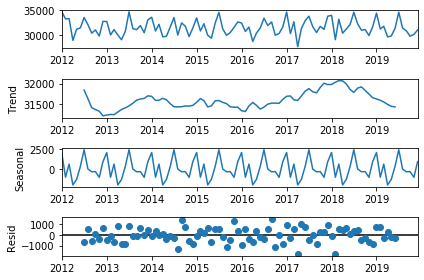

In [23]:
decomp_x = seasonal_decompose(x,  model='additive', period=12)
decomp_x.plot()
plt.show()

In [24]:
conso['Seasonal'] = decomp_x.seasonal.values
conso['Seasonal']

0     2070.052742
1    -1071.094582
2      598.387840
3    -2049.853500
4    -1347.637428
         ...     
91     -30.808181
92    -377.440606
93    -360.083324
94   -1082.564101
95     903.197322
Name: Seasonal, Length: 96, dtype: float64

In [25]:
conso['Désaisonnalisée'] = conso['Corrigés'] - conso['Seasonal']
conso

,Mois,Consommation_totale,Données_météo,Predicted,Corrigés,Seasonal,Désaisonnalisée
0,2012-01-01,51086,336,47923.127238,34756.658192,2070.052742,32686.605450
1,2012-02-01,54476,436,52783.050395,33286.735035,-1071.094582,34357.829617
2,2012-03-01,43156,202,41410.830207,33338.955223,598.387840,32740.567383
3,2012-04-01,40176,230,42771.608691,28998.176739,-2049.853500,31048.030238
4,2012-05-01,35257,83,35627.521650,31223.263780,-1347.637428,32570.901207
...,...,...,...,...,...,...,...
91,2019-08-01,31564,2,31690.983893,31466.801537,-30.808181,31497.609718
92,2019-09-01,32213,27,32905.964682,30900.820748,-377.440606,31278.261353
93,2019-10-01,36367,134,38106.082460,29854.702969,-360.083324,30214.786294
94,2019-11-01,43945,283,45347.367964,30191.417465,-1082.564101,31273.981566


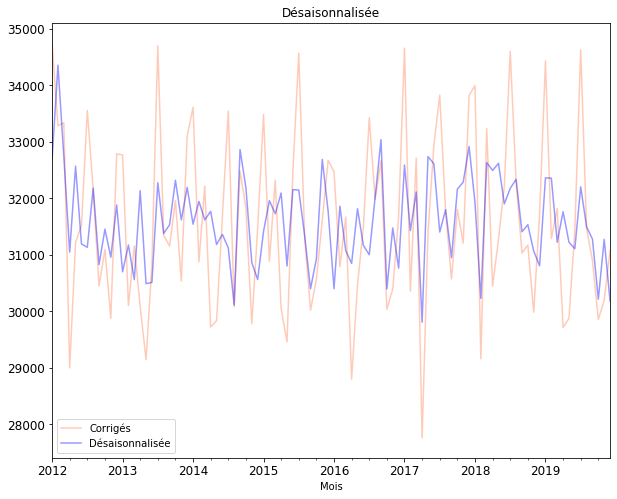

In [26]:
Désaisonnalisée = conso.loc[:,['Mois','Corrigés','Désaisonnalisée']]
Désaisonnalisée.plot(x ='Mois', alpha=0.4, color=['coral','blue', 'darkgreen'],figsize=(10, 8), title='Désaisonnalisée', fontsize=12)
plt.show()

Les pics sont gommés

# IV. Prévision de la consommation <a class="anchor" id="chapter4"></a>

In [27]:
x = conso.loc[:,['Mois','Corrigés']]
x = x.set_index(['Mois'])
x 

,Corrigés
Mois,
2012-01-01,34756.658192
2012-02-01,33286.735035
2012-03-01,33338.955223
2012-04-01,28998.176739
2012-05-01,31223.263780
...,...
2019-08-01,31466.801537
2019-09-01,30900.820748
2019-10-01,29854.702969


## 1) Méthode de Holt-Winters  <a class="anchor" id="section_4_1"></a>

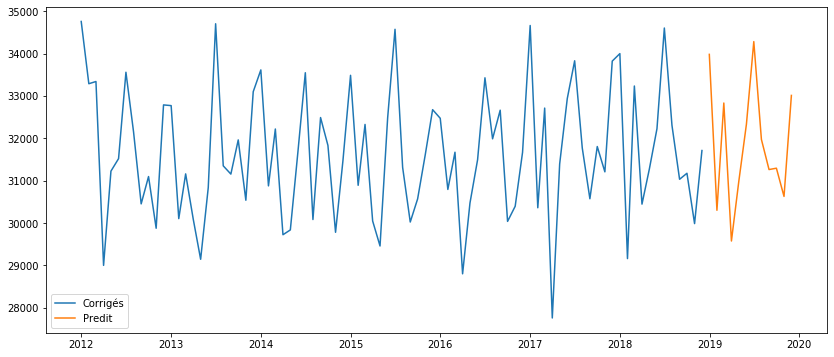

In [28]:
#Prédiction nouvelle série 

forecast = x.reset_index()
x_predict = forecast [(forecast['Mois'] <= '2018-12-01')]
x_2019 = forecast [(forecast['Mois'] > '2018-12-01')]
x_predict = x_predict.set_index(['Mois'])
x_predict

hw = ExponentialSmoothing(np.asarray(x_predict['Corrigés']), seasonal_periods=12, trend='mul', seasonal='mul').fit()

hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(x_predict['Corrigés'], label='Corrigés')
plt.plot(pd.date_range(x_predict.index[len(x_predict)-1], periods=12, freq='M'), hw_pred, label='Predit')
plt.legend()
plt.show()

In [29]:
x_2019 ['2019_Predicted'] = hw_pred
x_2019

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Mois,Corrigés,2019_Predicted
84,2019-01-01,34434.311214,33979.790257
85,2019-02-01,31286.405939,30298.906151
86,2019-03-01,31821.379044,32831.249500
87,2019-04-01,29713.729864,29573.540144
88,2019-05-01,29876.290675,30981.815042
89,2019-06-01,31431.618442,32330.865129
90,2019-07-01,34629.000000,34281.205066
91,2019-08-01,31466.801537,31971.791767
92,2019-09-01,30900.820748,31260.490695
93,2019-10-01,29854.702969,31292.458330


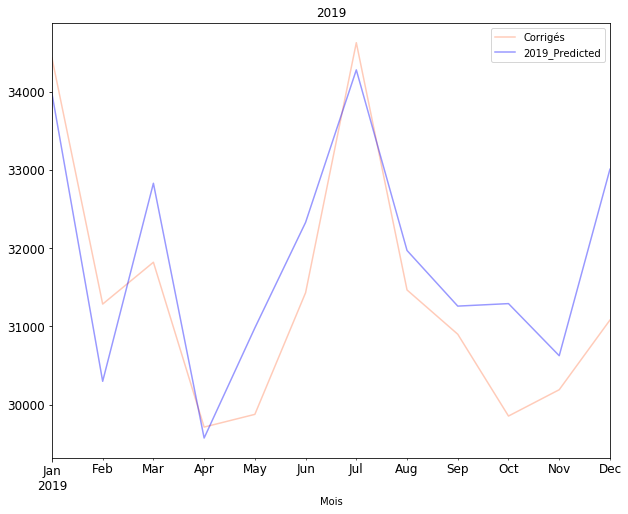

In [30]:
x_2019.plot(x ='Mois', alpha=0.4, color=['coral', 'blue'],figsize=(10, 8), title='2019', fontsize=12)
plt.show()

On calcule les RMSE et MAPE.

In [31]:
x_2019

,Mois,Corrigés,2019_Predicted
84,2019-01-01,34434.311214,33979.790257
85,2019-02-01,31286.405939,30298.906151
86,2019-03-01,31821.379044,32831.249500
87,2019-04-01,29713.729864,29573.540144
88,2019-05-01,29876.290675,30981.815042
89,2019-06-01,31431.618442,32330.865129
90,2019-07-01,34629.000000,34281.205066
91,2019-08-01,31466.801537,31971.791767
92,2019-09-01,30900.820748,31260.490695
93,2019-10-01,29854.702969,31292.458330


In [32]:
rmse = np.sqrt(((x_2019['Corrigés'] - x_2019['2019_Predicted'])**2).mean())
rmse

945.7561229588443

In [33]:
mape = (np.abs(1- x_2019['2019_Predicted'] / x_2019['Corrigés'])).mean()*100
mape 


2.5763914340391114

## 2) Méthode SARIMA <a class="anchor" id="section_4_2"></a>

#### Identification, estimation et validation de modèles

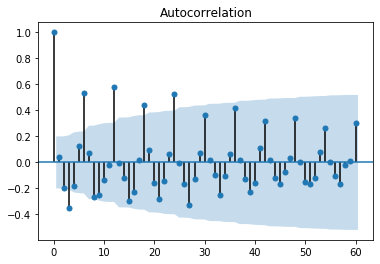

In [52]:
plot_acf(x['Corrigés'],lags = 60)
plt.show()

Il s'agit de la correlation de la série avec ses retards. Le point 0 marque la correlation de la série avec elle même, le point 1 avec la série décalée d'un mois.  
Au niveau du deuxième point, la correlation est nulle. On vérifie avec ce test que la série est stationnaire c'est à dire qu'on observe une décroissance lente vers 0.

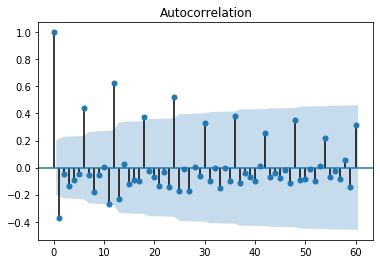

In [35]:
y_dif1 = x['Corrigés'] - x['Corrigés'].shift(1)
plot_acf(y_dif1[1:],lags = 60)
plt.show()

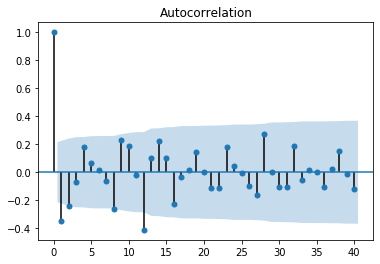

In [36]:
y_dif2 = y_dif1 - y_dif1.shift(12)
plot_acf(y_dif2[13:],lags = 40)
plt.show()

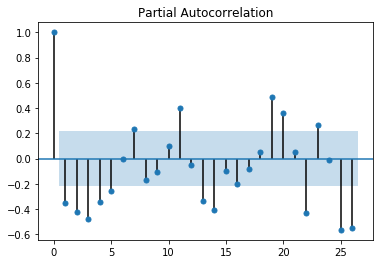

In [37]:
plot_pacf(y_dif2[13:],lags = 26)
plt.show()

#### Modèle 1

On estime en premier lieu un modèle $SARIMA(5,1,1)(0,1,1)_{12}$ au vu des autocorrélogrammes empiriques simples et partiels. Ce modèle s’écrit :

$$(I−φ_{1}B)(I−φ′_{1}B^{12})(I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

SARIMA (p,d,q)(P,D,Q)12  
q = dernier retard qui est non nul = ici 1 sur l'ACF  
d = 1 car une seule différenciation simple (1)  
D = 1 car une seule différenciation saisionnière (12)  
p = dernier retard qui est non nul = ici 5 sur l'PACF sur la partie simple  
Q = 1 car dernier retard non nul sur la partie saisonnière (multiple de 12) sur l'ACF  
P = dernier retard qui est non nul = ici 0 sur l'PACF sur la partie saisonnière   

In [38]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(x['Corrigés']), order=(5,1,1), seasonal_order=(0,1,1,12))
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(5, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -720.805
Date:                            Sun, 04 Jul 2021   AIC                           1457.609
Time:                                    23:27:13   BIC                           1476.960
Sample:                                         0   HQIC                          1465.383
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5646      0.786      0.718      0.473      -0.977       2.106
ar.L2         -0.0742      0.121   

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


#### Modèle 2

In [39]:
y_dif1

Mois
2012-01-01            NaN
2012-02-01   -1469.923157
2012-03-01      52.220188
2012-04-01   -4340.778484
2012-05-01    2225.087041
                 ...     
2019-08-01   -3162.198463
2019-09-01    -565.980789
2019-10-01   -1046.117778
2019-11-01     336.714496
2019-12-01     890.633811
Name: Corrigés, Length: 96, dtype: float64

Soit le modèle :
$$ (I−φ′_{1}B^{12})(I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [40]:
model2 = SARIMAX(np.asarray(x['Corrigés']), order=(4,1,1), seasonal_order=(0,1,1,12))
results2 = model2.fit()
print(results2.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -721.583
Date:                            Sun, 04 Jul 2021   AIC                           1457.167
Time:                                    23:27:14   BIC                           1474.098
Sample:                                         0   HQIC                          1463.969
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5098      0.579     -0.881      0.378      -1.644       0.624
ar.L2         -0.2068      0.107   

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Ce modèle ayant des paramètres non significatifs, on en teste un troisième.

#### Modèle 3

Soit le modèle :
$$ (I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t}$$

In [41]:
model3 = SARIMAX(np.asarray(x['Corrigés']), order=(3,1,1), seasonal_order=(0,1,1,12))
results3 = model3.fit()
print(results3.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -721.276
Date:                            Sun, 04 Jul 2021   AIC                           1454.551
Time:                                    23:27:15   BIC                           1469.064
Sample:                                         0   HQIC                          1460.382
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5089      0.368     -1.382      0.167      -1.231       0.213
ar.L2         -0.2232      0.065   

#### Modèle 4

In [42]:
model4 = SARIMAX(np.asarray(x['Corrigés']), order=(2,1,1), seasonal_order=(0,1,1,12))
results4 = model4.fit()
print(results4.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results4.resid, lags=elt)[1].mean()))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -723.253
Date:                            Sun, 04 Jul 2021   AIC                           1456.506
Time:                                    23:27:15   BIC                           1468.600
Sample:                                         0   HQIC                          1461.365
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2452      0.240      1.020      0.308      -0.226       0.716
ar.L2         -0.1186      0.061   

#### Modèle 5

In [43]:
model5 = SARIMAX(np.asarray(x['Corrigés']), order=(1,1,1), seasonal_order=(0,1,1,12))
results5 = model5.fit()
print(results5.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results5.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -724.156
Date:                            Sun, 04 Jul 2021   AIC                           1456.311
Time:                                    23:27:15   BIC                           1465.987
Sample:                                         0   HQIC                          1460.198
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5259      0.154      3.407      0.001       0.223       0.828
ma.L1         -0.6761      0.152   

Les Retard : p-value sont suppérieurs à 0,05 donc pas d'autocorrelation

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

Le test de normalité est également validé pour ce modèle.

#### Prévision à l’aide du modèle retenu (5) de l’année 2019

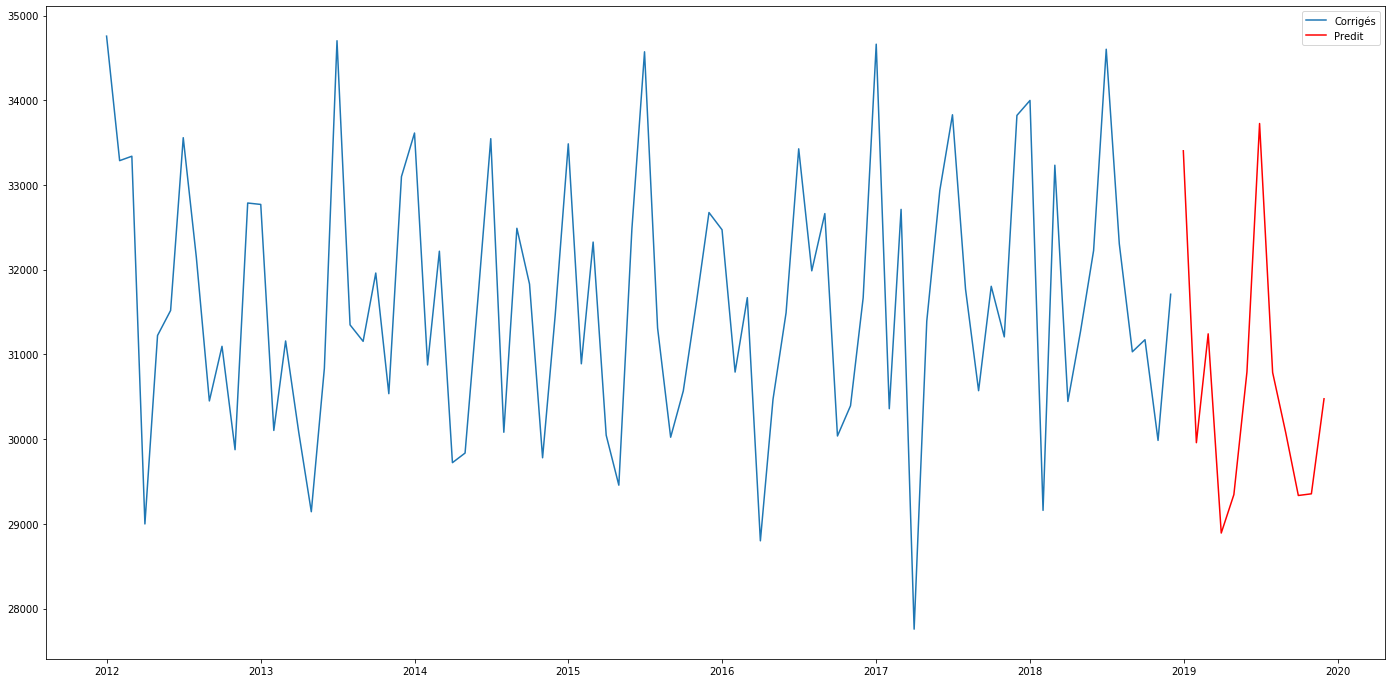

In [44]:
pred_model5 = results5.get_forecast(12)
pred = pred_model5.predicted_mean

plt.figure(figsize=(24,12))
plt.plot(x_predict['Corrigés'], label='Corrigés')
plt.plot(pd.date_range(x_predict.index[len(x_predict)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.legend()
plt.show()

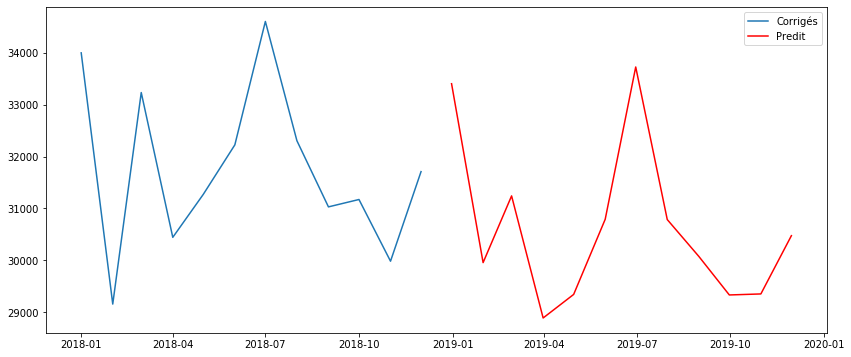

In [45]:
plt.figure(figsize=(14,6))
plt.plot(x_predict['Corrigés']['2018':], label='Corrigés')
plt.plot(pd.date_range(x_predict.index[len(x_predict)-1], periods=12, freq='M'), pred, color='r', label='Predit')

plt.legend()
plt.show()

In [46]:
x_2019 ['2019_Predicted_SAMIRA'] = pred
x_2019

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Mois,Corrigés,2019_Predicted,2019_Predicted_SAMIRA
84,2019-01-01,34434.311214,33979.790257,33403.128859
85,2019-02-01,31286.405939,30298.906151,29957.375410
86,2019-03-01,31821.379044,32831.249500,31242.299679
87,2019-04-01,29713.729864,29573.540144,28890.939847
88,2019-05-01,29876.290675,30981.815042,29344.525331
89,2019-06-01,31431.618442,32330.865129,30791.448146
90,2019-07-01,34629.000000,34281.205066,33725.203249
91,2019-08-01,31466.801537,31971.791767,30786.236410
92,2019-09-01,30900.820748,31260.490695,30077.464187
93,2019-10-01,29854.702969,31292.458330,29334.205612


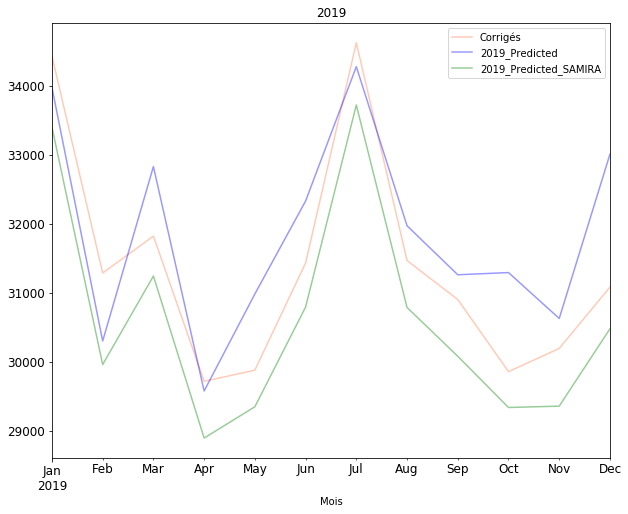

In [47]:
x_2019.plot(x ='Mois', alpha=0.4, color=['coral', 'blue', 'green'],figsize=(10, 8), title='2019', fontsize=12)
plt.show()

On calcule les RMSE et MAPE.

In [48]:
rmse = np.sqrt(((x_2019['Corrigés'] - x_2019['2019_Predicted_SAMIRA'])**2).mean())
rmse

807.8905040862319

In [49]:
mape = (np.abs(1- x_2019['2019_Predicted'] / x_2019['2019_Predicted_SAMIRA'])).mean()*100
mape

4.137817492180798

##### Comparer les deux modèls RMSE et MAPE 

rmse['2019_Predicted'] = 945.7561229588443 mape['2019_Predicted'] = 2.5763914340391114  
rmse['2019_Predicted_SAMIRA'] = 807.8905040862319 mape['2019_Predicted_SAMIRA'] = 4.137817492180798

mape 2.5763914340391114 = prévision érronnée de 2.5763914340391114  

rmse Hot wintlers > rmse SAMIRA
rmse SAMIRA est donc plus performant